# Modelo XGBoost

**Autor:** Mariluz Daniela Sánchez Morales 

**Descripción:** Este notebook realiza el desarrollo, entrenamiento y evaluación del modelo XGBoost utilizando distintas técnicas como el ajuste de hiperparámetros con GridSearchCV, validación cruzada estratificada (Stratified K-Fold), y análisis comparativo mediante métricas como AUC, TPR, FPR y curvas ROC.

In [1]:
%matplotlib inline

# Acceso a archivos
import os
import sys

# Visualización de métricas
import matplotlib.pyplot as plt

# Librería que divide en test y train el dataset, permite usar un stratified K-Fold, con la finalidad de revisar hiperparámetros
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
# Importación de el modelo a entrenar: XGBoost 
from xgboost import XGBClassifier

In [2]:
# Importación de funciones centralizadas
sys.path.append(os.path.abspath("../funciones"))

from funcionesEntrenamiento import (
    cargar_datos_entrenamiento,
    cargar_datos_prueba,
    imprimir_forma,
    division_train_val,
    reporte_clasificacion,
    crear_matriz_confusion,
    calcular_roc_auc,
    metricas_tpr_fpr,
    hacer_pepinillo
)

In [3]:
# Cargar datos y separar características y columna con las clases con función 
X, y = cargar_datos_entrenamiento()

shape, head = imprimir_forma(X)
print("Shape: ", shape)
head


Shape:  (1500, 1568)


,longitud_texto,num_palabras,comida,restriccion,purga,imagen_corporal,ejercicio,polaridad,subjetividad,tag_Anorexia,...,tfidf_1490,tfidf_1491,tfidf_1492,tfidf_1493,tfidf_1494,tfidf_1495,tfidf_1496,tfidf_1497,tfidf_1498,tfidf_1499
0,0.238798,-0.062255,0,0,0,0,0,1.168716,0.355986,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.536538,-1.607600,0,0,0,0,0,-0.346445,-1.134095,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.453282,-0.283019,3,2,0,0,0,0.789926,0.952018,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.329069,0.158508,0,0,0,1,0,1.774781,0.654002,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.784277,-0.724546,0,0,0,1,0,-1.331300,0.952018,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# División estratificada (80/20) con función
X_train, X_val, y_train, y_val = division_train_val(X,y)

train_shape, _ = imprimir_forma(X_train)
val_shape, _ = imprimir_forma(X_val)
print(f"Forma de conjunto de entrenamiento:", train_shape)
print(f"Forma de conjunto de validación:", val_shape)

Forma de conjunto de entrenamiento: (1200, 1568)
Forma de conjunto de validación: (300, 1568)


## Entrenamiento inicial de XGBoost

In [5]:
# Entrenamiento del modelo con parámetros default
xgb_inicial = XGBClassifier(random_state=22)

scores = cross_val_score(xgb_inicial, X_train, y_train, cv=5,scoring='roc_auc')

print("Resultados por fold:", scores)
print("Precisión promedio:", scores.mean())

Resultados por fold: [0.90568475 0.89419652 0.87551505 0.878976   0.93178013]
Precisión promedio: 0.8972304929903949


In [6]:
xgb_inicial.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [7]:
# Validación de modelo inicial y cálculo de métricas de evaluación
y_pred_inicial, y_proba_inicial, reporte_inicial = reporte_clasificacion(X_val, y_val, xgb_inicial)

print("Classification Report:")
print(reporte_inicial)

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.78      0.81       139
           1       0.82      0.88      0.85       161

    accuracy                           0.83       300
   macro avg       0.83      0.83      0.83       300
weighted avg       0.83      0.83      0.83       300



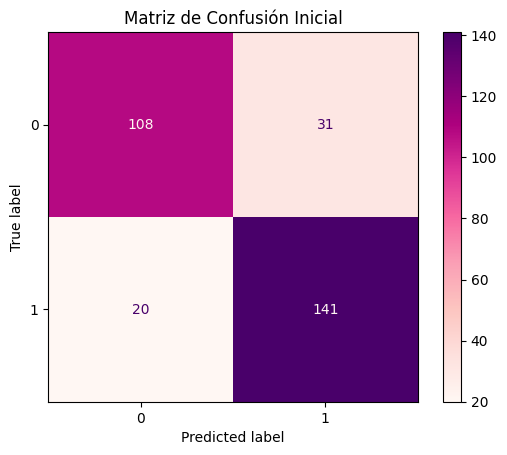

In [8]:
# Gráfica de matríz de confusión
cm_inicial, disp_inicial = crear_matriz_confusion(y_val, y_pred_inicial)
disp_inicial.plot(cmap='RdPu')
plt.title("Matriz de Confusión Inicial")
plt.show()

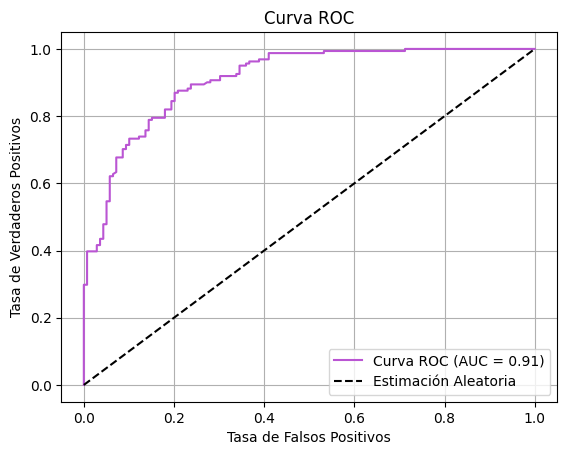

In [9]:
# Predicciones de probabilidad (para curva ROC)
fpr_inicial, tpr_inicial, thresholds_inicial, auc_score_inicial = calcular_roc_auc(y_val, y_proba_inicial)

# Gráfica de ROC
plt.figure()
plt.plot(fpr_inicial, tpr_inicial, color='mediumorchid', label=f"Curva ROC (AUC = {auc_score_inicial:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Estimación Aleatoria")
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [10]:
# Cálculo de métricas de desempeño de la matriz de confusión
TPR_inicial, FPR_inicial = metricas_tpr_fpr(cm_inicial)

# Mostrar métricas
print(f"AUC: {(auc_score_inicial * 100):.4f}")
print(f"TPR (Tasa de Positivos Verdaderos): {(TPR_inicial * 100):.4f}")
print(f"FPR (Tasa de Falsos Positivos): {(FPR_inicial * 100):.4f}")

AUC: 91.0496
TPR (Tasa de Positivos Verdaderos): 87.5776
FPR (Tasa de Falsos Positivos): 22.3022


## Busqueda de mejores parámetros (Entrenamiento y Validación)

In [11]:
# Modelo base para encontrar mejores parámetros
xgb = XGBClassifier(random_state=22)

# Parámetros a buscar con GridSearchSV  
param_grid = {
    'n_estimators': [500, 600, 700],
    'max_depth': [1, 2, 3, 4],
    'learning_rate': [0.20, 0.25, 0.30, 0.35],
    'subsample': [0.6, 0.8, 1],
    'eval_metric' : ['logloss', 'auc', 'error', 'aucpr', 'poisson-nloglik', 'gamma-nloglik']
}

# Cross-validation estratificada
cv = StratifiedKFold(
    n_splits=5, 
    shuffle=True, 
    random_state=22
)

# GridSearch
grid = GridSearchCV(
    estimator=xgb, 
    param_grid=param_grid, 
    cv=cv, 
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1,
    error_score='raise'
)

In [12]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=22, shuffle=True),
             error_score='raise',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     g...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'eval_metric': ['logloss', 'auc', 'error', 'aucpr',
                                         'poisson-nloglik', 'gamma-nloglik'],
                         'learning_rate': [0.2, 0.25, 0.3], 'max_depth': [1, 2],
                         'n_estimators': [500, 600, 700],
                         'subsample': [0.8, 1]},
             scoring='roc_auc', verbose=1)

In [14]:
# Ver mejores hiperparámetros encontrados
grid.best_params_

{'eval_metric': 'logloss',
 'learning_rate': 0.25,
 'max_depth': 1,
 'n_estimators': 600,
 'subsample': 1}

In [16]:
# Creación de modelo con los mejores parámetros
best_xgb = XGBClassifier(
    eval_metric='logloss',
    n_estimators=600,
    max_depth=1,
    learning_rate=0.25,
    subsample=1,
    random_state=22,
)

best_xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.25, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=600, n_jobs=None,
              num_parallel_tree=None, ...)

In [17]:
# Validación del modelo
y_pred, y_proba, reporte = reporte_clasificacion(X_val, y_val, best_xgb)

print("Classification Report:")
print(reporte)

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.78      0.82       139
           1       0.83      0.89      0.86       161

    accuracy                           0.84       300
   macro avg       0.84      0.84      0.84       300
weighted avg       0.84      0.84      0.84       300



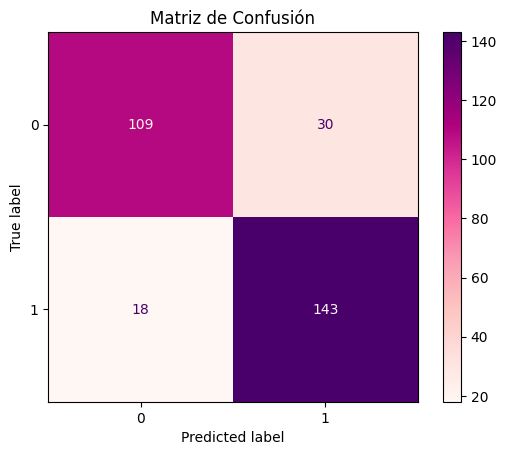

In [18]:
# Matriz de confusión
cm, disp = crear_matriz_confusion(y_val, y_pred)
disp.plot(cmap="RdPu")
plt.title("Matriz de Confusión")
plt.show()

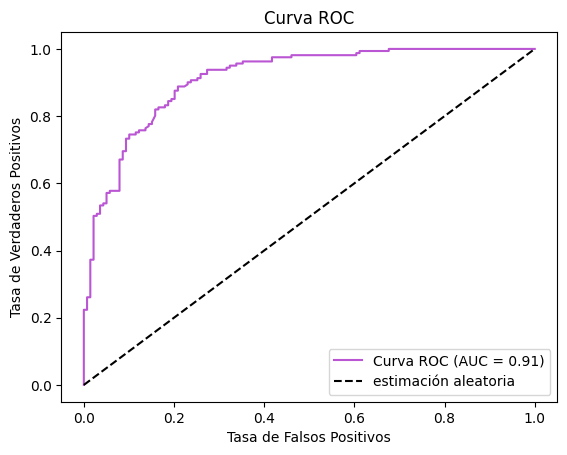

In [19]:
# Predicciones de probabilidad (para curva ROC)
fpr, tpr, thresholds, auc_score = calcular_roc_auc(y_val, y_proba)

# Gráfica de ROC
plt.plot(fpr, tpr, color='mediumorchid', label=f"Curva ROC (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], "k--", label='estimación aleatoria')
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.show()

In [20]:
# Cálculo de métricas de desempeño de la matriz de confusión
TPR, FPR = metricas_tpr_fpr(cm)

# Mostrar métricas
print(f"AUC: {(auc_score * 100):.4f}")
print(f"TPR (Tasa de Verdaderos Positivos): {(TPR * 100):.4f}")
print(f"FPR (Tasa de Falsos Positivos): {(FPR * 100):.4f}")

AUC: 91.3111
TPR (Tasa de Verdaderos Positivos): 88.8199
FPR (Tasa de Falsos Positivos): 21.5827


## Modelo Final (Entrenamiento y Prueba)

In [23]:
# Modelo entrenado con todos los datos de ds_tradicional
modelXGB = XGBClassifier(
    eval_metric='logloss',
    n_estimators=600,
    max_depth=1,
    learning_rate=0.25,
    subsample=1,
    random_state=22,
)

modelXGB.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.25, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=1, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=600, n_jobs=None,
              num_parallel_tree=None, ...)

In [24]:
# Cargar datos y separar características y columna con las clases con función 
X_test, y_test = cargar_datos_prueba()

shape_test, head_test = imprimir_forma(X_test)
print("Shape: ", shape_test)
head_test

Shape:  (250, 1568)


,longitud_texto,num_palabras,comida,restriccion,purga,imagen_corporal,ejercicio,polaridad,subjetividad,tag_Anorexia,...,tfidf_1490,tfidf_1491,tfidf_1492,tfidf_1493,tfidf_1494,tfidf_1495,tfidf_1496,tfidf_1497,tfidf_1498,tfidf_1499
0,-0.393101,-0.503783,0,1,0,0,0,0.966695,1.349373,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.315037,2.366144,0,1,0,1,1,-0.194929,0.542246,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.874548,-0.724546,2,2,0,0,0,-0.346445,-1.134095,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.178617,-0.283019,1,3,0,1,0,-0.346445,-1.134095,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.315037,3.249199,1,3,0,0,0,-0.346445,-1.134095,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
#Prueba del modelo final
y_pred_test, y_proba_test, reporte_test = reporte_clasificacion(X_test, y_test, modelXGB)

print("Classification Report:")
print(reporte_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.73      0.77       116
           1       0.79      0.85      0.82       134

    accuracy                           0.80       250
   macro avg       0.80      0.79      0.79       250
weighted avg       0.80      0.80      0.79       250



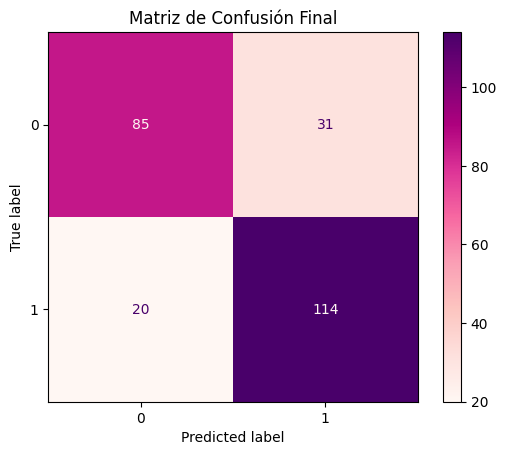

In [26]:
# Matriz de confusión
cm_test, disp_test = crear_matriz_confusion(y_test, y_pred_test)

disp_test.plot(cmap="RdPu")
plt.title("Matriz de Confusión Final")
plt.show()

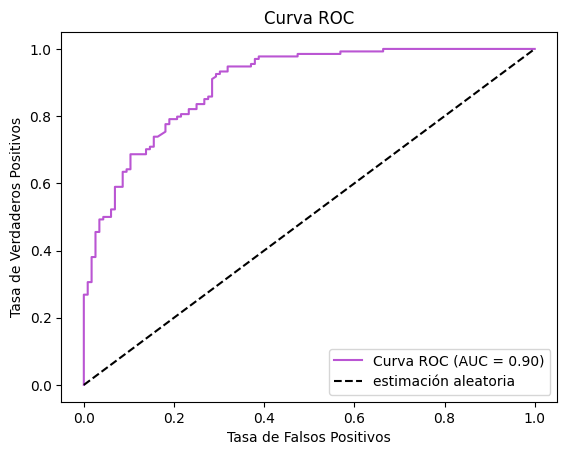

In [27]:
# Predicciones de probabilidad (para curva ROC)
fpr_test, tpr_test, thresholds_test, auc_score_test = calcular_roc_auc(y_test, y_proba_test)

# Gráfica ROC
plt.plot(fpr_test, tpr_test,color='mediumorchid', label=f"Curva ROC (AUC = {auc_score_test:.2f})")
plt.plot([0, 1], [0, 1], "k--", label='estimación aleatoria')
plt.xlabel("Tasa de Falsos Positivos")
plt.ylabel("Tasa de Verdaderos Positivos")
plt.title("Curva ROC")
plt.legend(loc="lower right")
plt.show()

In [28]:
# Cálculo de métricas de desempeño de la matriz de confusión
TPR_Test, FPR_Test = metricas_tpr_fpr(cm_test)

# Mostrar métricas
print(f"AUC: {(auc_score_test * 100):.4f}")
print(f"TPR (Tasa de Verdaderos Positivos): {(TPR_Test * 100):.4f}")
print(f"FPR (Tasa de Falsos Positivos): {(FPR_Test * 100):.4f}")

AUC: 89.5748
TPR (Tasa de Verdaderos Positivos): 85.0746
FPR (Tasa de Falsos Positivos): 26.7241


In [29]:
# Guardado del modelo final en un archivo pickle
hacer_pepinillo(modelXGB, "modelXGB.pkl")